In [1]:
import numpy as np
import csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.recurrent import LSTM
import matplotlib.pyplot as plt
import math

Using TensorFlow backend.


In [88]:
# results become repeatable
np.random.seed(0)
import  keras
print(keras.__version__)
#import tensorflow as tf
#print(tf.__version__)

1.2.2


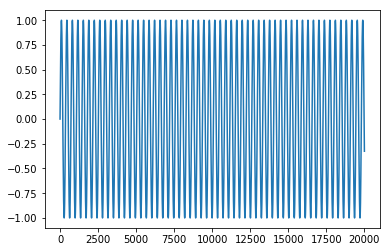

In [89]:
# generate sine wave
sine_data = np.array([math.sin(i*np.pi/180) for i in range(0,20000)],dtype='float32')
plt.figure()
plt.plot(sine_data)
plt.show()

In [90]:
# load the Stock data
data = []
# csv header: Date	Open	High	Low 	Last	Close	Total Trade Quantity	Turnover (Lacs)
# we are only interested in Last closing price in this excercise
with open('./NSE-RELIANCE.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        data.append(line[4])
# convert the data from string to float in the list
data = [float(i) for i in data]
data = np.array(data)  # convert to numpy array
# choose either the external data or sine wave
Flag_sine = False
if Flag_sine:
    data = sine_data

In [91]:
data[0:10]

array([ 1432.1 ,  1434.8 ,  1427.75,  1411.05,  1407.  ,  1387.1 ,
        1377.35,  1360.  ,  1312.  ,  1319.  ])

In [92]:
def preparedata(data,seq_len,normalize_dataflag=True):
    '''
    This function takes the data and generates desired number of batches and sequences
    sequences are generated by shifting by 1 datapoint
    '''
    data_len = len(data)
    data_new = []
    target   = []
    seq_len = seq_len + 1 # take one extra because last one will be the target for the sequence
    for i in range(data_len-seq_len):
        x = data[i:i+seq_len]
        if normalize_dataflag:
            norm = normalizedata(x)
            
        else:
            norm = x
        data_new.append(norm[:-1])
        target.append(norm[-1])
    data_new = np.array(data_new, dtype='float32') 
    target   = np.array(target, dtype='float32')
    return data_new, target

def normalizedata(x):
    '''
    Normalizes the data as ni = p0/pi-1 % percentage change in the sequence length window
    '''
    return x / x[0] - 1


In [93]:
data_prep, target_prep = preparedata(data, seq_len=50, normalize_dataflag=True)

In [94]:
len(data_prep[-1])

50

In [95]:
data_prep = np.reshape(data_prep, data_prep.shape + (1,)) # LSTM in keras assumes 3D input (Batchzise, time_dim, feature_dim)
data_prep.shape

(4753, 50, 1)

In [98]:
# prepare a train/ val/ test set
X_train, X_test, y_train, y_test = train_test_split(data_prep, target_prep, test_size = 0.10, random_state = 100)


In [111]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4277, 50, 1), (476, 50, 1), (4277,), (476,))

In [101]:
def lstm_model(batch_len=64, seq_len=50, dropout=0.2, lr=0.001):
    model = Sequential()
    # add a 1st LSTM layer
    model.add(LSTM(output_dim=50, input_shape=(seq_len,1), return_sequences=True)) # just provide (time_dim,feature_dim) as input shape
    #model.add(LSTM(output_dim=64, input_dim=1, return_sequences=True))
    # add a drop out layer
    model.add(Dropout(dropout))
    # add a 2nd LSTM layer
    model.add(LSTM(100, return_sequences=False))
    # add a drop out layer
    model.add(Dropout(dropout))
    # add a dense layer
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.summary()
    adam = Adam(lr = lr)
    model.compile(optimizer= adam, loss='mse', metrics=['accuracy']) 
    #model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    return model
    

In [102]:
batch_len = 512
seq_len   = 50
dropout   = 0.5
learning_rate = 0.001
model = lstm_model(batch_len=batch_len, seq_len=seq_len, dropout=dropout, lr=learning_rate)
model.fit(X_train, y_train, batch_size=batch_len, nb_epoch=30, validation_split=0.1, verbose=1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_35 (LSTM)                   (None, 50, 50)        10400       lstm_input_18[0][0]              
____________________________________________________________________________________________________
dropout_35 (Dropout)             (None, 50, 50)        0           lstm_35[0][0]                    
____________________________________________________________________________________________________
lstm_36 (LSTM)                   (None, 100)           60400       dropout_35[0][0]                 
____________________________________________________________________________________________________
dropout_36 (Dropout)             (None, 100)           0           lstm_36[0][0]                    
___________________________________________________________________________________________

In [103]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    #predicted = np.reshape(predicted, (predicted.size,))
    return predicted
yy = predict_point_by_point(model, X_test)
yy.shape

(476, 1)

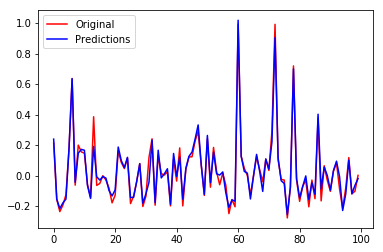

In [109]:
plt.figure()
plt.plot(y_test[0:100], color='red', label='Original')
plt.plot(yy[0:100], color='blue', label='Predictions')
plt.legend(loc='upper left')
plt.show()